In [1]:
import os
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from attention import Attention

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("train.csv")

In [3]:
data

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0
...,...,...,...
3995,every time i try to edit a page or create a li...,tools,0
3996,unable to load money using wallets (phonepe/ol...,Unable to load money using wallets,0
3997,"hi, i m doing for the first time ever and i no...",usage,0
3998,delivery is delayed or cancelled every time i ...,Delivery,0


<AxesSubplot:xlabel='label', ylabel='count'>

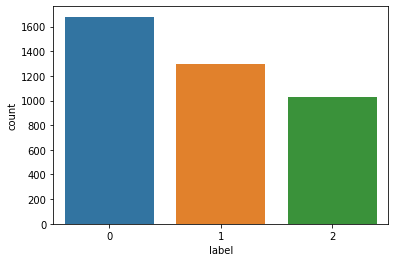

In [4]:
sns.countplot(x='label', data=data)

In [5]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

data['text'] = data['text'].apply(preprocess_text)
data['aspect'] = data['aspect'].apply(preprocess_text)

In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['text'])

In [7]:
tokenized_text = tokenizer.texts_to_sequences(data['text'])
tokenized_aspect = tokenizer.texts_to_sequences(data['aspect'])

In [8]:
embedded_text=pad_sequences(tokenized_text,padding='pre',maxlen=120)
print(embedded_text)

embedded_aspect=pad_sequences(tokenized_aspect,padding='pre',maxlen=8)
print(embedded_aspect)

[[  0   0   0 ... 128 278 592]
 [  0   0   0 ...   3 593 101]
 [  0   0   0 ...   4  90 395]
 ...
 [  0   0   0 ...   9  17   6]
 [  0   0   0 ...  43 168 325]
 [  0   0   0 ...  47   4 603]]
[[   0    0    0 ...    0    0  278]
 [   0    0    0 ...    0    0   55]
 [   0    0    0 ...    0    0  527]
 ...
 [   0    0    0 ...    0    0 2426]
 [   0    0    0 ...    0    0   22]
 [   0    0    0 ...    0   82   47]]


In [9]:
len(embedded_text),len(embedded_aspect),data['label'].shape

(4000, 4000, (4000,))

In [10]:
X1=np.array(embedded_text)
X2=np.array(embedded_aspect)
y=np.array(data['label'])

In [11]:
embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [12]:
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((5000, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Found 400000 word vectors.


In [13]:
input_1 = Input(shape=(120,))

input_2 = Input(shape=(8,))

In [14]:
embedding_layer_1 = Embedding(5000, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128,return_sequences=True)(embedding_layer_1)
attention_1 = Attention(128)(LSTM_Layer_1)

In [15]:
embedding_layer_2 = Embedding(5000, 100,weights=[embedding_matrix], trainable=False)(input_2)
LSTM_Layer_2 = LSTM(32)(embedding_layer_2)

In [16]:
concat_layer = Concatenate()([attention_1,LSTM_Layer_2])
dense_layer_1 = Dense(15, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_1)
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 120, 100)     500000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 120, 128)     117248      embedding[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 128)          0           lstm[0][0]                       
______________________________________________________________________________________________

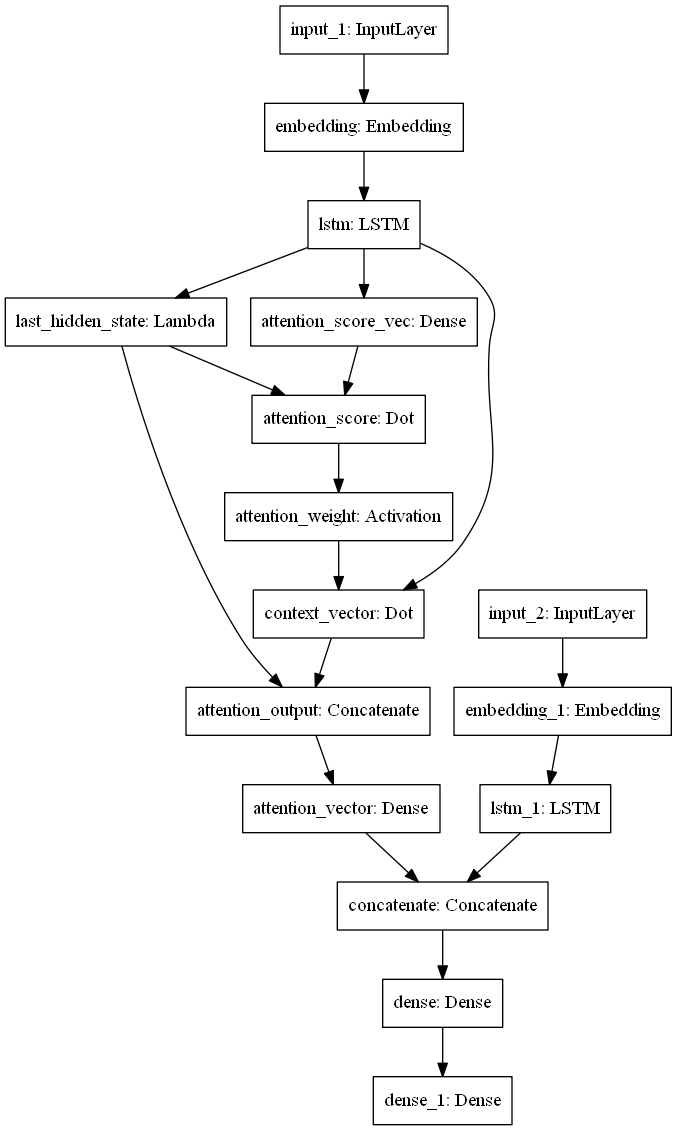

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
X1.shape

(4000, 120)

In [20]:
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1,X2, y, test_size=0.1, random_state=42)
print('Train text data len:'+str(len(X1_train)))
print('Train aspect data len:'+str(len(X2_train)))
print('Class distribution\n'+str((pd.Series(y_train)).value_counts()))
print()
print('Test text data len:'+str(len(X1_test)))
print('Test aspect data len:'+str(len(X2_test)))
print('Class distribution\n'+str((pd.Series(y_test)).value_counts()))

Train text data len:3600
Train aspect data len:3600
Class distribution
0    1501
1    1170
2     929
dtype: int64

Test text data len:400
Test aspect data len:400
Class distribution
0    179
1    124
2     97
dtype: int64


In [21]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [22]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=72, epochs=8, verbose=1, validation_split=0.2)

Epoch 1/8
40/40 [==============================] - 11s 217ms/step - loss: 1.0168 - acc: 0.4708 - val_loss: 0.9658 - val_acc: 0.5194
Epoch 2/8
40/40 [==============================] - 8s 195ms/step - loss: 0.8521 - acc: 0.6042 - val_loss: 0.8526 - val_acc: 0.6014
Epoch 3/8
40/40 [==============================] - 9s 225ms/step - loss: 0.7565 - acc: 0.6653 - val_loss: 0.7922 - val_acc: 0.6389
Epoch 4/8
40/40 [==============================] - 9s 229ms/step - loss: 0.6994 - acc: 0.6920 - val_loss: 0.7793 - val_acc: 0.6389
Epoch 5/8
40/40 [==============================] - 9s 230ms/step - loss: 0.6691 - acc: 0.7094 - val_loss: 0.7606 - val_acc: 0.6472
Epoch 6/8
40/40 [==============================] - 9s 229ms/step - loss: 0.6244 - acc: 0.7281 - val_loss: 0.7880 - val_acc: 0.6375
Epoch 7/8
40/40 [==============================] - 9s 230ms/step - loss: 0.5879 - acc: 0.7490 - val_loss: 0.7725 - val_acc: 0.6528
Epoch 8/8
40/40 [==============================] - 9s 230ms/step - loss: 0.5310 - 

In [23]:
loss,accuracy=model.evaluate([X1_test,X2_test],y_test)

print('Accuracy: {}'.format(round(accuracy,2)))
print('Loss: {}'.format(round(loss,2)))

13/13 [==============================] - 1s 49ms/step - loss: 0.6481 - acc: 0.7175
Accuracy: 0.72
Loss: 0.65


In [24]:
model.predict([X1_test,X2_test])

array([[6.2661749e-01, 1.3244382e-01, 2.4093869e-01],
       [8.0507350e-01, 4.4884528e-03, 1.9043811e-01],
       [4.2628440e-01, 1.8848605e-04, 5.7352710e-01],
       ...,
       [4.0343854e-01, 5.8667701e-01, 9.8844999e-03],
       [4.1639462e-02, 2.1881562e-01, 7.3954493e-01],
       [2.2370034e-01, 7.7177095e-01, 4.5286422e-03]], dtype=float32)

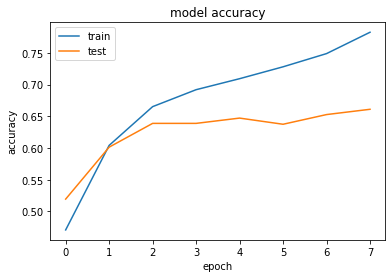

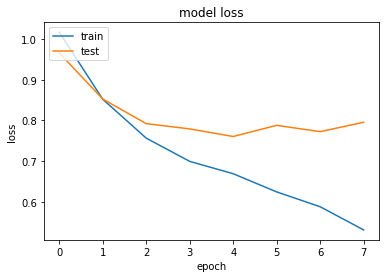

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()